# Analysis on correlation between mainshocks and surface mass loading

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/SLIM/loadquakes.py'>

### Load datasets (GRACE and declustered catalog)

In [2]:
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Events from 2002-04-16 to 2021-12-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [3]:
catalog

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1
0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,5.723209e-11,0.921824,8.553738e-04,1.0
1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,5.723209e-11,0.921494,1.212914e-03,1.0
2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,5.723209e-11,0.922613,4.521355e-07,1.0
3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,5.723209e-11,0.920187,2.629352e-03,1.0
4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,5.723209e-11,0.921931,7.395483e-04,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,5.723209e-11,0.910348,1.329390e-02,1.0
12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,5.723209e-11,0.922595,1.943847e-05,1.0
12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,5.723209e-11,0.908502,1.529500e-02,1.0
12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,5.723209e-11,0.922196,4.520215e-04,1.0


### Define mainshocks as events that have less than 90% chance of being triggered

In [4]:
mainshock = catalog[catalog['P_triggered']<.9]
mainshock.sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1
7166,7168,57.3560,162.1980,2010-05-02 06:23:23.390,5.4,POINT (57.356 162.198),5.4,0.0,5.723209e-11,0.881894,0.044135,1.0
4303,4305,-26.9899,26.7048,2014-08-05 10:22:33.980,5.4,POINT (-26.9899 26.7048),5.4,0.0,5.723209e-11,0.324056,0.648763,1.0
10356,10358,-7.2170,119.6290,2005-08-07 04:51:34.930,5.4,POINT (-7.217 119.629),5.4,0.0,5.723209e-11,0.889205,0.036211,1.0
4273,4275,64.6928,-17.3877,2014-08-28 08:13:42.220,5.4,POINT (64.69280000000001 -17.3877),5.4,0.0,5.723209e-11,0.673949,0.269521,1.0
4265,4267,-11.5502,-112.0034,2014-09-02 23:41:30.170,5.4,POINT (-11.5502 -112.0034),5.4,0.0,5.723209e-11,0.609412,0.339472,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8514,8516,31.0020,103.3220,2008-05-12 06:28:01.570,7.9,POINT (31.002 103.322),5.4,0.0,5.723209e-11,0.355678,0.614489,1.0
2402,2404,56.0039,-149.1658,2018-01-23 09:31:40.890,7.9,POINT (56.0039 -149.1658),5.4,0.0,5.723209e-11,0.778755,0.155924,1.0
1606,1608,-5.8119,-75.2697,2019-05-26 07:41:15.073,8.0,POINT (-5.8119 -75.2697),5.4,0.0,5.723209e-11,0.887509,0.038049,1.0
10932,10934,-49.3120,161.3450,2004-12-23 14:59:04.410,8.1,POINT (-49.312 161.345),5.4,0.0,5.723209e-11,0.881399,0.044671,1.0


In [4]:
# pd.options.mode.chained_assignment = 'warn'

### Add surface load to the earthquake and mainshock dataframes

In [5]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

<ipython-input-5-62d8ffe61e8d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)


#### Are the mean/meadian values different between: 1. The whole dataset, 2. times with earthquakes, and 3. times with mainshocks?
The answer appears to be: no, not really. The Bayesian analysis explains why! It's because mainshocks are favored at large positive AND negative surface loads. The symmetry implies that the means don't change much.

In [6]:
print('Mainshock mean:   %f'%mainshock['dmass'].mean())
print('Mainshock median: %f'%mainshock['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

Mainshock mean:   0.524257
Mainshock median: 0.429636
Earthquake mean:   0.827411
Earthquake median:   1.054229
<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)
<xarray.DataArray 'lwe_thickness' ()>
array(0.7491707)


In [6]:
# # Distribution of all mainshocks

# gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(mainshock.longitude, mainshock.latitude))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
# gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
# leg = ax.legend()

## Correlation between mainshocks and surface mass loading

#### Both statistical tests produce p-values < 0.05, which indicate that the two samples are not drawn from the same distribution. This means that the distribution of surface mass load during earthquake occurrence is significantly different from background.

In [11]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)
# loadquakes.calc_stats(np.array(mainshock.dmass),np.array(ds['lwe_thickness'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=10.228910981911213, pvalue=2.6813524733881877e-09),
 'ks': KstestResult(statistic=0.05792248416472967, pvalue=0.002155718604685016),
 'median_all': 0.749170696239575,
 'median_eq': 0.4296356781869296,
 'mean_all': -0.65387517841372,
 'mean_eq': 0.5242571588960425,
 'mean_all_minus_mean_eq': -1.1781323373097625,
 'median_all_minus_median_eq': 0.3195350180526454}

23
22


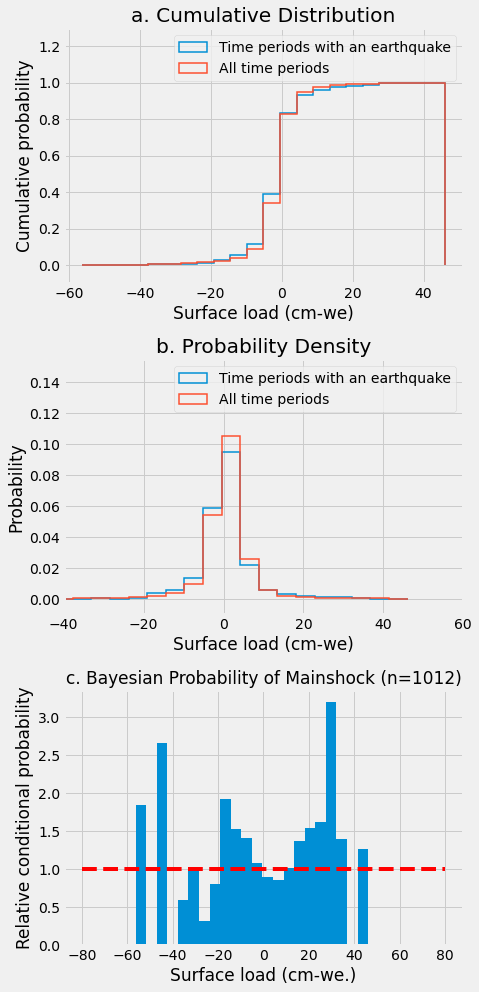

In [279]:
importlib.reload(loadquakes)
def set_of_figures_load(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(7,14))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist(all_time, earthquake_only, ax1, ax2, 
              'a. Cumulative Distribution', 'b. Probability Density')

    loadquakes.plot_bayes(all_time, earthquake_only, ax3, 
                  'c. Bayesian Probability of Mainshock (n=1012)',
                         method='Sturge')

    fig.tight_layout()
set_of_figures_load(ds['lwe_thickness'].data.flatten(), mainshock.dmass)

23
22
108
107


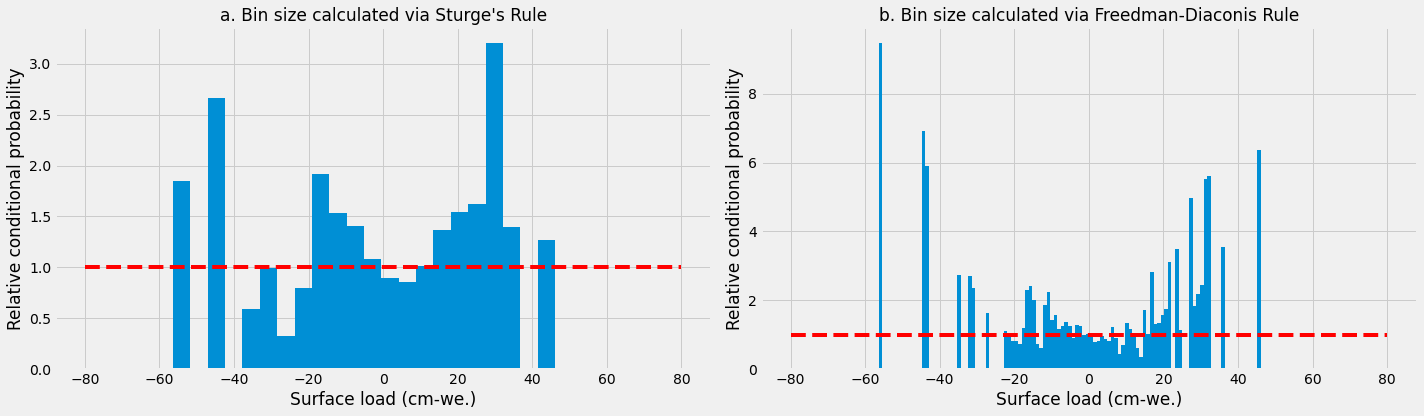

In [295]:
importlib.reload(loadquakes)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,6))

plt.style.use('fivethirtyeight')
    
loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), mainshock.dmass, ax1,
                      "a. Bin size calculated via Sturge's Rule", method = 'Sturge')

loadquakes.plot_bayes(ds['lwe_thickness'].data.flatten(), mainshock.dmass, ax2,
                      "b. Bin size calculated via Freedman-Diaconis Rule", method = 'fd')

fig.tight_layout()


In [171]:
def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
    return(result)

In [296]:
freedman_diaconis(data=mainshock.dmass, returnas="bins")

/home/amand4/.local/lib/python3.9/site-packages/scipy/stats/stats.py:2836: VisibleDeprecationWarning: use of scale='raw' is deprecated, use scale=1.0 instead
  warnings.warn(


108

## Mapping earthquakes with high conditional probability

### First, calculate the conditional probability of each mainshock

<ipython-input-14-dd635c4c8f2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['cp'] = conditional_probability


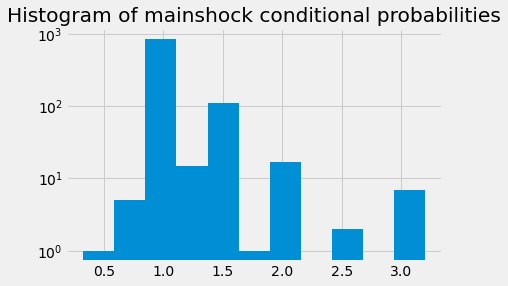

In [14]:
conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(mainshock.dmass), np.array(mainshock.dmass))
mainshock['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(mainshock['cp']),11)
plt.title('Histogram of mainshock conditional probabilities')
plt.yscale('log')
# mainshock[mainshock.cp > 1.5].sort_values('cp')

### Next, map the events that have a conditional probability > 1.5                                       

In [195]:
mainshock[mainshock["cp"]>1.5].sort_values("cp")

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp,loading_rate
189,191,38.8893,135.4527,2021-09-29 08:37:05.619,6.1,POINT (38.8893 135.4527),5.4,0.0,5.723209e-11,0.841772,0.087622,1.0,-12.225786974842901,1.535216,-5.3028709314120555
4582,4584,4.1909,86.7252,2014-03-27 04:00:15.540,5.4,POINT (4.1909 86.7252),5.4,0.0,5.723209e-11,0.750910,0.186105,1.0,-11.71227395695825,1.535216,0.18678229680209313
4786,4788,26.4118,93.6451,2013-11-06 04:16:16.060,5.4,POINT (26.4118 93.6451),5.4,0.0,5.723209e-11,0.892164,0.033003,1.0,-10.686518954217602,1.535216,-7.646599272510171
5100,5102,28.4280,51.5930,2013-04-09 11:52:49.920,6.4,POINT (28.428 51.593),5.4,0.0,5.723209e-11,0.884665,0.041132,1.0,-10.115252682952107,1.535216,-1.0899054408073425
5418,5420,40.7470,48.4370,2012-10-07 11:42:47.160,5.4,POINT (40.747 48.437),5.4,0.0,5.723209e-11,0.878157,0.048185,1.0,-11.228397315648156,1.535216,-3.479058809611823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11862,11864,22.8540,92.3060,2003-07-26 23:18:17.960,5.7,POINT (22.854 92.306),5.4,0.0,5.723209e-11,0.848145,0.080714,1.0,31.68322316970908,3.199615,45.34269900901109
9383,9385,43.2240,133.5260,2007-03-09 03:22:42.760,6.0,POINT (43.224 133.526),5.4,0.0,5.723209e-11,0.862740,0.064896,1.0,29.623508036954767,3.199615,25.326031357049942
7680,7682,20.4040,94.7930,2009-09-21 19:38:42.330,5.7,POINT (20.404 94.79300000000001),5.4,0.0,5.723209e-11,0.880868,0.045246,1.0,29.83249363185799,3.199615,11.524887524545193
8332,8334,25.0390,97.6970,2008-08-21 12:24:30.930,6.0,POINT (25.039 97.697),5.4,0.0,5.723209e-11,0.821593,0.109493,1.0,27.661881541722572,3.199615,12.596650783896555


In [305]:
mainshock[mainshock["cp"]>2]

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp,loading_rate
1336,1338,7.3210,-35.4035,2019-11-13 13:44:05.000,5.5,POINT (7.321 -35.4035),5.4,0.0,5.723209e-11,0.899783,0.024745,1.0,28.53071476660423,3.199615,0.44545185565948486
2288,2290,35.2588,132.5528,2018-04-08 16:32:31.520,5.7,POINT (35.2588 132.5528),5.4,0.0,5.723209e-11,0.896463,0.028344,1.0,-43.92857012271674,2.666922,8.275502681732178
4410,4412,40.3731,51.5739,2014-06-07 06:05:29.910,5.5,POINT (40.3731 51.5739),5.4,0.0,5.723209e-11,0.776742,0.158106,1.0,-43.05570164414012,2.666922,6.404501478108436
7680,7682,20.4040,94.7930,2009-09-21 19:38:42.330,5.7,POINT (20.404 94.79300000000001),5.4,0.0,5.723209e-11,0.880868,0.045246,1.0,29.83249363185799,3.199615,11.524887524545193
8332,8334,25.0390,97.6970,2008-08-21 12:24:30.930,6.0,POINT (25.039 97.697),5.4,0.0,5.723209e-11,0.821593,0.109493,1.0,27.661881541722572,3.199615,12.596650783896555
9383,9385,43.2240,133.5260,2007-03-09 03:22:42.760,6.0,POINT (43.224 133.526),5.4,0.0,5.723209e-11,0.862740,0.064896,1.0,29.623508036954767,3.199615,25.326031357049942
10466,10468,28.8810,94.6260,2005-06-01 20:06:41.450,5.8,POINT (28.881 94.626),5.4,0.0,5.723209e-11,0.779481,0.155138,1.0,31.35207431117368,3.199615,3.0792596616390355
11826,11828,29.5730,95.6050,2003-08-18 09:03:03.520,5.5,POINT (29.573 95.605),5.4,0.0,5.723209e-11,0.613404,0.335145,1.0,31.84687742437117,3.199615,-4.540490914629476
11862,11864,22.8540,92.3060,2003-07-26 23:18:17.960,5.7,POINT (22.854 92.306),5.4,0.0,5.723209e-11,0.848145,0.080714,1.0,31.68322316970908,3.199615,45.34269900901109


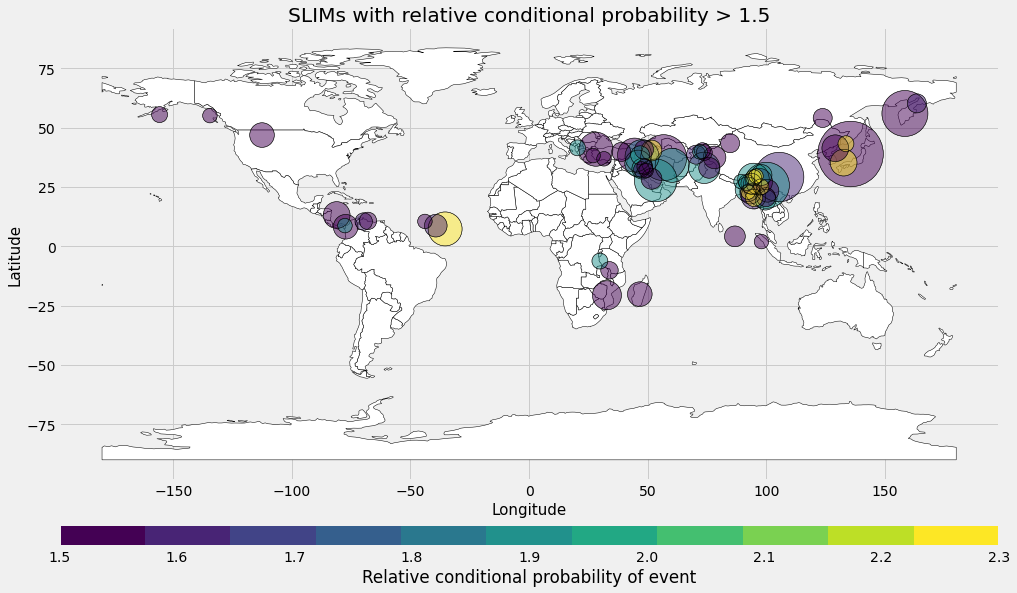

In [199]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

events_highcp = mainshock[mainshock['cp']>1.5]

def probability_map_cb(events,color,label):

    gdf = gpd.GeoDataFrame(events,
                           geometry=gpd.points_from_xy(events.longitude, 
                                                       events.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cmap = cm.get_cmap('viridis', 11)    # 11 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize = 1e-5*np.sort(events.magnitude)[::-1]**10,
             legend_kwds={'label': "Relative conditional probability of event",
                            'orientation': "horizontal"},
            vmax=2.3,
            vmin=1.5)
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize = 1e-5*np.sort(events.magnitude)[::-1]**10)
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(events_highcp,events_highcp.cp,
                'SLIMs with relative conditional probability > 1.5')

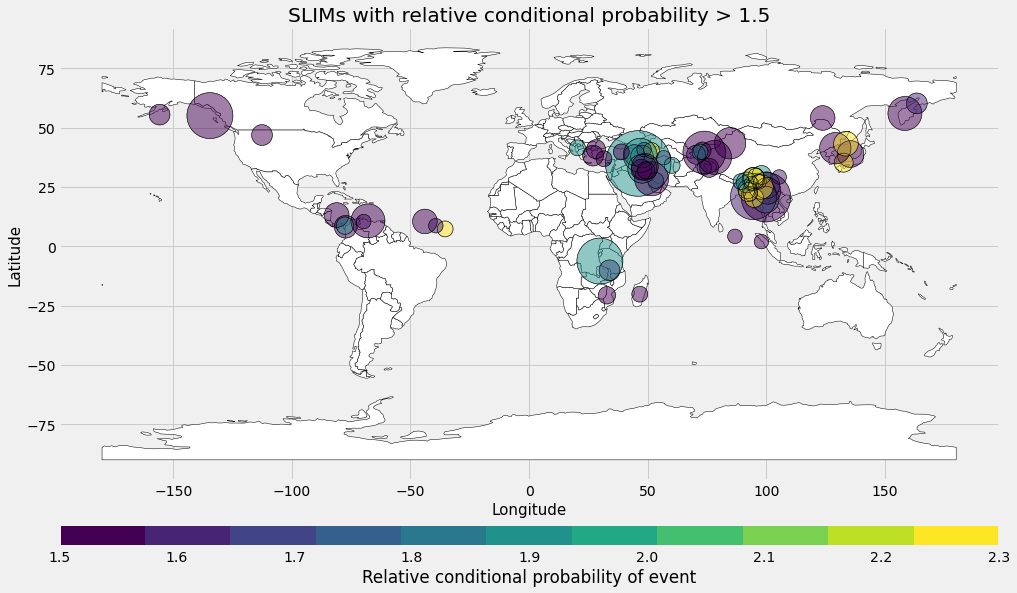

In [194]:
def probability_map_cb(events,color,label):

    gdf = gpd.GeoDataFrame(events,
                           geometry=gpd.points_from_xy(events.longitude, 
                                                       events.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cmap = cm.get_cmap('viridis', 11)    # 11 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize = 1e-5*(events.magnitude)**10,
             legend_kwds={'label': "Relative conditional probability of event",
                            'orientation': "horizontal"},
            vmax=2.3,
            vmin=1.5)
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize = 1e-5*(events.magnitude)**10)
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(events_highcp,events_highcp.cp,
                'SLIMs with relative conditional probability > 1.5')

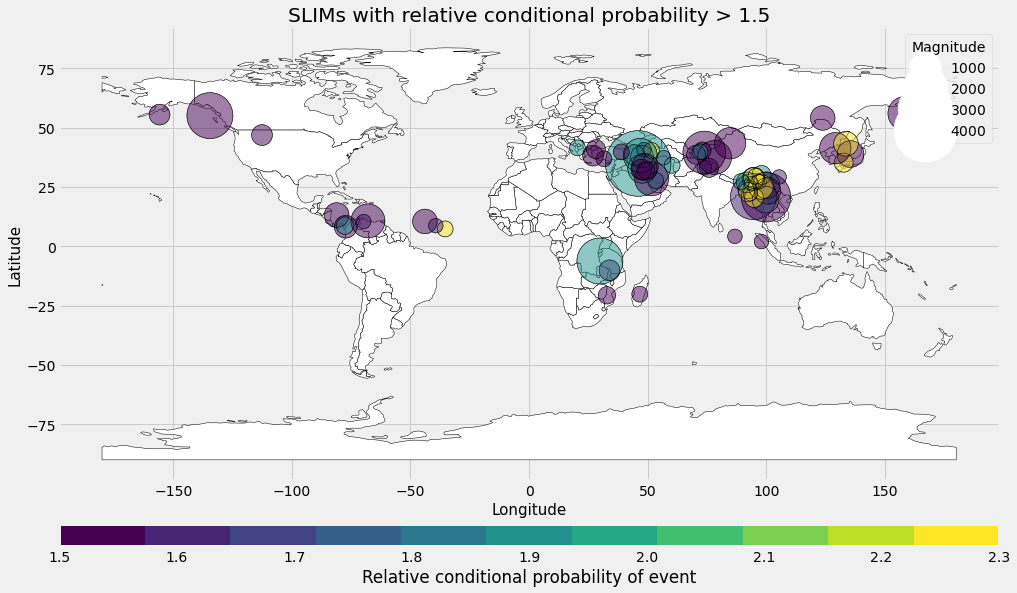

In [248]:
events_highcp = mainshock[mainshock['cp']>1.5]

def probability_map_cb(events,color,label):

    gdf = gpd.GeoDataFrame(events,
                           geometry=gpd.points_from_xy(events.longitude, 
                                                       events.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cmap = cm.get_cmap('viridis', 11)    # 11 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize = 1e-5*(events.magnitude)**10,
             legend_kwds={'label': "Relative conditional probability of event",
                            'orientation': "horizontal"},
            vmax=2.3,
            vmin=1.5)
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize = 1e-5*(events.magnitude)**10)

    legend2 = ax.legend(handles, labels, loc="upper right", title="Magnitude")
    
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(events_highcp,events_highcp.cp,
                'SLIMs with relative conditional probability > 1.5')

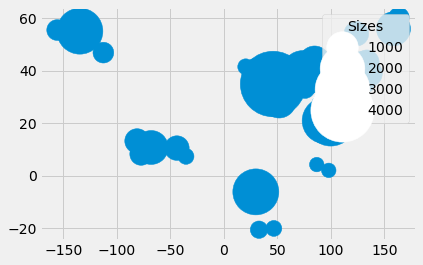

In [247]:
fig, ax = plt.subplots()

s=1e-5*events_highcp.magnitude**10
scatter = ax.scatter(events_highcp.longitude,events_highcp.latitude, s=s)

# produce a legend with a cross section of sizes from the scatter
kw = dict(prop="sizes", num=4, color='w',
          func=lambda s: s)
handles, labels = scatter.legend_elements(**kw) 
# labels = ['$\\mathdefault{5}$',
#           '$\\mathdefault{6}$',
#           '$\\mathdefault{7}$']

legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()

In [63]:
high_p = mainshock[mainshock["cp"]>1.5]
high_p[high_p["longitude"]<-100]

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp
2625,2627,46.8811,-112.5753,2017-07-06 06:30:17.000,5.8,POINT (46.8811 -112.5753),5.4,0.0,5.736547e-11,0.216708,0.765096,1.0,-10.294337778718495,1.547613
9460,9462,55.4948,-155.7421,2007-01-05 16:52:19.932,5.8,POINT (55.4948 -155.7421),5.4,0.0,5.736547e-11,0.872818,0.053897,1.0,21.576949719668733,1.680710
11190,11192,55.0721,-134.5324,2004-06-28 09:49:51.366,6.8,POINT (55.0721 -134.5324),5.4,0.0,5.736547e-11,0.893879,0.031067,1.0,-9.780644302562038,1.547613


# Correlation between earthquakes and random data
##### *mean and std deviation of random array same as GRACE data 

In [31]:
np.mean(ds['lwe_thickness'])

<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)

In [33]:
np.std(ds['lwe_thickness'])

<xarray.DataArray 'lwe_thickness' ()>
array(25.49255185)

In [34]:
random_load1 = np.random.normal(loc=-0.65387518, scale=25.49255185, size=(205, 360, 720))

In [35]:
ds_random = ds

In [36]:
ds_random = ds_random.assign(load=ds_random['lwe_thickness'] - ds_random['lwe_thickness'] + random_load1)

In [40]:
ds_random['load']

<xarray.DataArray 'load' (time: 205, lat: 360, lon: 720)>
array([[[-8.56593213e+00,  4.32775485e+01, -3.78524724e+01, ...,
          2.06349824e+01,  2.25533974e+01,  1.18418980e+00],
        [-2.99311477e+01,  1.00510712e+01, -1.14225441e+01, ...,
         -1.88059359e+01, -4.31123140e+00, -1.69421751e+01],
        [-1.41169681e+00, -1.62756247e+00,  2.04810107e+01, ...,
         -3.91371414e+01, -6.11803190e-01,  3.02792807e+01],
        ...,
        [-6.67335672e-01, -1.21415720e+00,  5.90528498e+00, ...,
          8.84132516e+00, -2.76712864e-01, -1.38168039e+01],
        [ 8.42255331e+00, -3.65049725e+00,  2.28978673e+00, ...,
         -2.56837433e+01, -1.43097831e+01,  1.56570988e+01],
        [-1.64807910e+01, -2.38317403e+01, -2.82620593e+01, ...,
          2.25645599e+01,  2.44028099e+01, -1.66900377e+01]],

       [[ 2.49263562e+01, -9.29776560e+00, -4.70449661e-01, ...,
          5.19903413e+00,  3.60287222e+00,  3.60399482e+01],
        [ 2.78320452e+01,  1.40209985e+00, -2.48174631e+01, ...,
          7.70396616e+00,  2.47026507e+01, -1.23322802e+01],
        [ 7.93080947e-01,  3.79241593e+01, -3.64954864e+01, ...,
          3.55416368e+01,  3.65746521e+01, -1.51993859e+01],
...
        [-3.04384863e+01,  6.38891751e+00, -2.08134559e+01, ...,
          7.38091569e+00,  1.51075793e+01,  2.68733420e+01],
        [-3.53125492e+01,  3.66909915e+00, -8.34933357e+00, ...,
          2.30733198e+01, -9.28506626e+00,  1.63870968e+01],
        [ 1.13081219e+01,  3.40979693e+01, -2.87795864e+01, ...,
          2.04901673e+01, -3.06401445e+01,  3.21349135e+01]],

       [[-5.00856817e+01, -3.29024214e+01, -1.61966804e+01, ...,
         -2.73969905e+01,  2.45506726e+01,  8.88861041e+00],
        [-6.38607208e+00, -6.36179003e-01,  2.38121040e+01, ...,
         -2.79661900e+01,  2.13438689e+01, -1.37354252e+01],
        [-4.98400103e+01, -2.07257367e+01, -1.04502243e+01, ...,
          1.98463032e+00, -1.09041036e+01, -1.30975589e+00],
        ...,
        [-4.27125327e+00, -2.98493575e+01,  2.13701638e+01, ...,
          2.12120553e+01, -8.63937361e+00,  2.22669030e+01],
        [ 9.93749701e+00,  1.40526416e+01,  2.16983427e-01, ...,
         -1.94979350e+01,  1.40015344e+01, -2.11496574e+01],
        [-2.73321517e+01,  3.25441399e+01,  8.48230763e+00, ...,
         -2.61575502e+00,  8.60790714e+00, -1.34113302e+01]]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2022-01-16T12:00:00
  * lon      (lon) float64 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75

In [41]:
# earthquake catalog

mainshock_random = catalog[catalog['P_triggered']<.9]

In [42]:
def get_mass_random(eq):
    mass_change = ds_random.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["load"]
    return mass_change.data
  
mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)

<ipython-input-42-1efc1d20fd8f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)


In [43]:
np.mean(mainshock_random['dmass'])

-2.050043806666062

In [44]:
np.std(mainshock_random['dmass'])

25.819268456667572

23
22


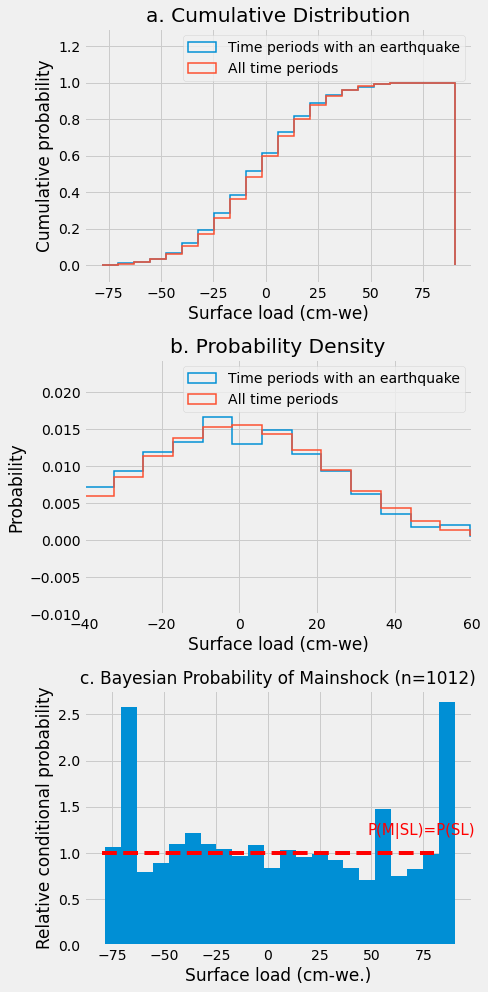

In [45]:
set_of_figures_load(ds_random['load'].data.flatten(), mainshock_random.dmass)

In [46]:
stats.ks_2samp(mainshock_random.dmass,ds_random['load'].data.flatten())

KstestResult(statistic=0.03585760820470518, pvalue=0.1446111234948736)